<img src="https://img.fotocommunity.com/moos-beetle-d710277f-b1cc-473a-a286-e689fcb79490.jpg?height=1080"
width="350">

# Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt
import os, json, cv2, random
import math
from google.colab.patches import cv2_imshow
from PIL import Image
import random
import copy
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Загрузка архива

In [7]:
# !unzip -qq /content/drive/MyDrive/My_Notebooks/Sila_Sveta/data.zip -d /content/drive/MyDrive/My_Notebooks/Sila_Sveta/

In [8]:
f = open('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/data.json')
json = json.load(f)

# Смотрим

In [9]:
json.keys()

dict_keys(['initial_bundle', 'test_bundle'])

In [10]:
initial_bundle = json['initial_bundle']
test_bundle = json['test_bundle']
print(f'Длина initial_bundle = {len(initial_bundle)}, длина test_bundle = {len(test_bundle)}')

Длина initial_bundle = 1558, длина test_bundle = 1545


In [11]:
type(json)

dict

In [12]:
# Хотела сохранить каждую часть словаря отдельно, но это не понадобилось:

# with open('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/initial_bundle.json', 'w') as ib:
#   json.dump(initial_bundle, ib)

# with open('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/test_bundle.json', 'w') as tb:
#   json.dump(test_bundle, tb) 

## посмотрим любое изображение

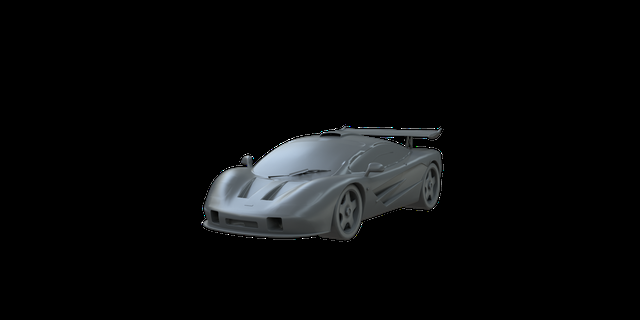

In [13]:
# посмотрим любое
image = cv2.imread('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/data/064fbc80-71cf-4888-bedf-b6dc33266dc4.png')
cv2_imshow(image)

# Разбираемся со словарями

In [14]:
initial_bundle[0]

{'category': {'id': 133,
  'name': 'Installations',
  'type': {'id': 20, 'name': 'Showcase & Finals'}},
 'file': 'data/bf0d8c12-950b-4760-8deb-3a562cd7fe5b.jpg',
 'id': 2703,
 'subcategory': None,
 'tags': ['2022', 'doha', 'fan', 'fifa', 'fooball', 'qatar', 'zone'],
 'type': {'id': 20, 'name': 'Showcase & Finals'}}

In [15]:
test_bundle[0]

{'category': {'id': 11,
  'name': 'Plants',
  'type': {'id': 1, 'name': '3D Models'}},
 'file': 'data/7e5ba16b-6223-41f3-8f64-07ea079ece48.png',
 'id': 2472,
 'subcategory': {'category': {'id': 11,
   'name': 'Plants',
   'type': {'id': 1, 'name': '3D Models'}},
  'id': 98,
  'name': 'Home'},
 'tags': ['decor', 'outdoor', 'plants', 'pot', 'street', 'urban'],
 'type': {'id': 1, 'name': '3D Models'}}

In [16]:
def getting_from(bundle, key_1, key_2):
  l = []
  for dictionaty in bundle:
    l.append(dictionaty[key_1][key_2])
    list_of_key2 = set(l)
  return list_of_key2

In [17]:
ib_category_name = getting_from(initial_bundle, 'category', 'name')
# tb_category_name = getting_from(test_bundle, 'category', 'name') - выдаёт ошибку, посмотрим, почему:

In [18]:
# вот, почему: есть фото БЕЗ присвоенной категории:
t = []
e = []
for dictionaty in test_bundle:
  try:
    t.append(dictionaty['category']['name'])
  except:
    e.append(dictionaty['file'])
tb_category_name = set(t)
tb_category_without_name = set(e)

tb_category_without_name

{'data/3586ff8d-98c4-4480-a644-63e43e120f55.png',
 'data/a240223c-da46-45ff-bfe5-b14887289860.png'}

## получилось вот сколько категорий всего:

In [19]:
print(f'Длина списка названий категорий из initial_bundle = {len(ib_category_name)}, длина списка названий категорий из test_bundle = {len(tb_category_name)}')

Длина списка названий категорий из initial_bundle = 73, длина списка названий категорий из test_bundle = 71


## посмотрим виды категорий

In [20]:
# ib_category_name 
# тут было много всего - нам подходят 'Plants' и 'Vehicles'

In [21]:
# tb_category_name 
# нам также подходят 'Plants' и 'Vehicles'

## что это за img без категории:

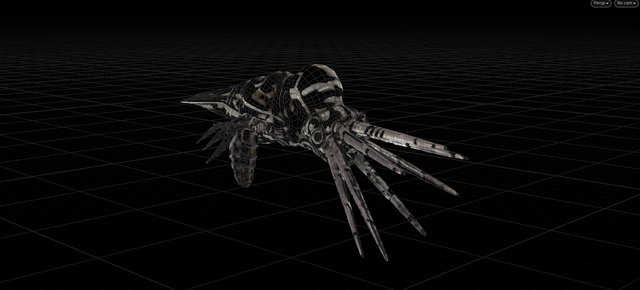

data/a240223c-da46-45ff-bfe5-b14887289860.png


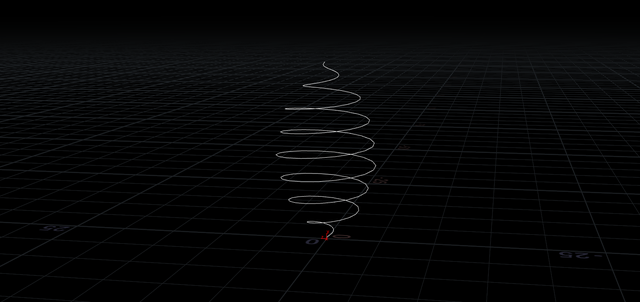

data/3586ff8d-98c4-4480-a644-63e43e120f55.png


In [ ]:
for img in tb_category_without_name:
  image = cv2.imread(f'/content/drive/MyDrive/My_Notebooks/Sila_Sveta/{img}')
  cv2_imshow(image)
  print(img)

# разделим на папки

## создадим папки для перемещния img

In [19]:
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/plants
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/vehicles
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/other

# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/plants
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/vehicles
# !mkdir /content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/other

## def copy_img()

In [20]:
# т.к. 2 файла без категории мешали при копировании, решено было их удалить:
# !rm '/content/drive/MyDrive/My_Notebooks/Sila_Sveta/data/a240223c-da46-45ff-bfe5-b14887289860.png'
# !rm '/content/drive/MyDrive/My_Notebooks/Sila_Sveta/data/3586ff8d-98c4-4480-a644-63e43e120f55.png'

# for dict in test_bundle:
#   if dict['file'] == 'data/3586ff8d-98c4-4480-a644-63e43e120f55.png' or dict['file'] == 'data/a240223c-da46-45ff-bfe5-b14887289860.png':
#     dict.clear()

In [22]:
def copy_img(bundle, data_folder_to_move):
  for dict in bundle:
    if not dict:
      pass
    elif dict['category']['name']=='Plants':
      try:
        !cp "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/f'{dict['file']}'" "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/{data_folder_to_move}/plants"
      except:
        print("Не получилось копировать файл f'{dict['file']}'")
        pass        
    elif dict['category']['name']=='Vehicles':
      try:
        !cp "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/f'{dict['file']}'" "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/{data_folder_to_move}/vehicles"
      except:
        print("Не получилось копировать файл f'{dict['file']}'")
        pass        
    else:
      try:
        !cp "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/f'{dict['file']}'" "/content/drive/MyDrive/My_Notebooks/Sila_Sveta/{data_folder_to_move}/other"
      except:
        print("Не получилось копировать файл f'{dict['file']}'")
        pass

In [22]:
# разделяем!

# copy_img(initial_bundle, 'train_data')
# copy_img(test_bundle, 'valid_data')

## проверим, всё ли скопировано

In [23]:
print(
    len(initial_bundle) == 
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/other')) + 
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/vehicles')) + 
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data/plants'))
)

True


In [24]:
# тут всё верно, т.к. в test_bundle было 2 пустых словаря:
print(
    len(test_bundle) -
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/other')) -
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/vehicles')) -
    len(os.listdir('/content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/plants'))
    )


2


# МОДЕЛЬ

## transforms.Compose

In [25]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## делим на train_set и val_set

In [26]:
train_set = datasets.ImageFolder("/content/drive/MyDrive/My_Notebooks/Sila_Sveta/train_data", transform = transformations)
val_set = datasets.ImageFolder("/content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data", transform = transformations)

In [27]:
print(f'Набор классов у train_set - {train_set.classes}, набор индексов классов у train_set- {train_set.class_to_idx}')
print(f'Набор классов у val_set - {val_set.classes}, набор индексов классов у val_set- {val_set.class_to_idx}')

Набор классов у train_set - ['other', 'plants', 'vehicles'], набор индексов классов у train_set- {'other': 0, 'plants': 1, 'vehicles': 2}
Набор классов у val_set - ['other', 'plants', 'vehicles'], набор индексов классов у val_set- {'other': 0, 'plants': 1, 'vehicles': 2}


## train_loader и val_loader

In [28]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

## model

In [29]:
# берём предтренированную, в которой будем заменять классификатор:
model = models.densenet161(pretrained=True) #ResNet densenet161
# обучать её заново мы не будем, т.е. пусть она НЕ обновляет градиенты:
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [30]:
# создаём новый классификатор:
classifier_input = model.classifier.in_features
num_labels = 3 # (plants, vehicles and other)
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# меняем классификатор модели на наш новый:
model.classifier = classifier

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## loss-fn & optimizer

In [34]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters())

## training loop

In [35]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)        # Clear optimizers
        optimizer.zero_grad()        # Forward pass
        output = model.forward(inputs)        # Loss
        loss = criterion(output, labels)        # Calculate gradients (backpropogation)
        loss.backward()        # Adjust parameters based on gradients
        optimizer.step()        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)            # Forward pass
            output = model.forward(inputs)            # Calculate Loss
            valloss = criterion(output, labels)            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

1 / 49
2 / 49
3 / 49
4 / 49
5 / 49
6 / 49
7 / 49
8 / 49
9 / 49
10 / 49
11 / 49
12 / 49
13 / 49
14 / 49
15 / 49
16 / 49
17 / 49
18 / 49
19 / 49
20 / 49
21 / 49
22 / 49
23 / 49
24 / 49
25 / 49
26 / 49
27 / 49
28 / 49
29 / 49
30 / 49
31 / 49
32 / 49
33 / 49
34 / 49
35 / 49
36 / 49
37 / 49
38 / 49
39 / 49
40 / 49
41 / 49
42 / 49
43 / 49
44 / 49
45 / 49
46 / 49
47 / 49
48 / 49
49 / 49
1 / 49
2 / 49
3 / 49
4 / 49
5 / 49
6 / 49
7 / 49
8 / 49
9 / 49
10 / 49
11 / 49
12 / 49
13 / 49
14 / 49
15 / 49
16 / 49
17 / 49
18 / 49
19 / 49
20 / 49
21 / 49
22 / 49
23 / 49
24 / 49
25 / 49
26 / 49
27 / 49
28 / 49
29 / 49
30 / 49
31 / 49
32 / 49
33 / 49
34 / 49
35 / 49
36 / 49
37 / 49
38 / 49
39 / 49
40 / 49
41 / 49
42 / 49
43 / 49
44 / 49
45 / 49
46 / 49
47 / 49
48 / 49
49 / 49
Accuracy:  0.898870262564445
Epoch: 0 	Training Loss: 0.299466 	Validation Loss: 0.275541
1 / 49
2 / 49
3 / 49
4 / 49
5 / 49
6 / 49
7 / 49
8 / 49
9 / 49
10 / 49
11 / 49
12 / 49
13 / 49
14 / 49
15 / 49
16 / 49
17 / 49
18 / 49
19 / 49
2

# Работа с предсказанием по изображению

In [36]:
# переводим модель в eval
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## def process_image()

In [37]:
def process_image(image_path):
    # загружаем
    img = Image.open(image_path)
    
    # получаем размеры
    width, height = img.size
    #print(img.size)
    
    # ресайзим, сохраняя отношения сторон, но изменяя размерность
    # наименьшая сторона - 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    #print('строка 12', img.size)

    # получаем размеры нового img
    width, height = img.size
    
    # устанавливаем координаты, чтобы сделать обрезку 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom)) 
    #print('строка 23',img.size)

    # Превращаем image в numpy array - ТУТ получается 4ый слой - на 2 индексе!!!
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # добавили, чтобы не было 4 вместо 3 цветовых слов!
    #print('строка 28', img.shape)

    # Делаем transpose, чтобы color channel dimension стоял первым, а не последним
    img = img.transpose((2, 0, 1))
    #print('строка 32', img.shape)
    
    # Нормализуем
    img = img/255
    
    # Нормализация делается через preset mean и standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    #print('строка 41', img.shape)

    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    #print('строка 46', img.shape)
    
    # Превращаем в torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

## def predict()

In [38]:
def predict(image, model):
    # пропускаем img через модель
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Получаем the top predicted class и % вероятности этого класса
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

## def full_cycle()

In [39]:
def full_cycle(img_path):
  image = process_image(img_path) # подготавливаем наш img
  top_prob, top_class = predict(image.to(device), model.to(device)) # подаём в модеь и предсказываем
  
  img = cv2.imread(img_path)
  cv2_imshow(img)
  print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

## проверяем, как работает

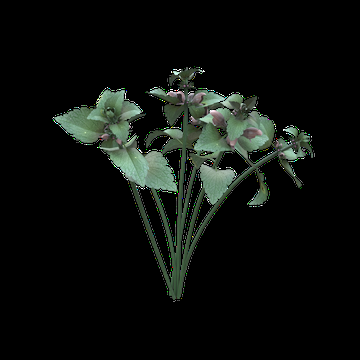

The model is  99.59359169006348 % certain that the image has a predicted class of  1


In [40]:
img_path = '/content/drive/MyDrive/My_Notebooks/Sila_Sveta/valid_data/plants/13522982-6e54-4ee7-b32e-a0c4266bd933.png'
full_cycle(img_path)

# ИТОГО

Помним, что набор индексов классов: {'other': 0, 'plants:': 1, 'vehicles': 2}

## def full_cycle_without_show()

In [42]:
def full_cycle_without_show(img_path):
  image = process_image(img_path) # подготавливаем наш img
  top_prob, top_class = predict(image.to(device), model.to(device)) # подаём в модель и предсказываем
  if top_class == 0:
    top_class = 'other'
  elif top_class == 1:
    top_class = 'plants'
  elif top_class == 2:
    top_class = 'vehicles'
  else:
    top_class = "can't determinate the class"
  return top_prob, top_class
  # print("The model is ", round(top_prob*100, 2), "% certain that the image has a predicted class of", top_class)

## def make_dataframe()

In [46]:
def make_dataframe(data_folder):
  list_of_folders = []
  list_of_img = []
  list_of_pred_class = []
  list_of_prob = []

  for folder_name in ("other/", "plants/", "vehicles/"):
    folder_path = os.path.join("/content/drive/MyDrive/My_Notebooks/Sila_Sveta/" + data_folder, folder_name) # дописать на разные папки
    for img_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_name)
      top_prob, top_class = full_cycle_without_show(img_path)

      list_of_folders.append(folder_name)
      list_of_img.append(img_name)
      list_of_pred_class.append(top_class)
      list_of_prob.append(round(top_prob*100, 2))

  data = {'Папка': list_of_folders,
          'Image': list_of_img,
          'Предсказанный класс': list_of_pred_class,
          'Вероятность предсказания': list_of_prob}
  dataframe = pd.DataFrame(data)
  dataframe.to_csv("/content/drive/MyDrive/My_Notebooks/Sila_Sveta/" + data_folder + ".csv")
  print(dataframe.head(10))

In [47]:
make_dataframe('train_data')

    Папка                                     Image Предсказанный класс  \
0  other/  cfac0a78-339e-4f6e-ae0d-0729890c776e.jpg               other   
1  other/  7bcb3d1f-1f94-4443-a6b5-84c16aaa1b3b.jpg               other   
2  other/  193df100-3b3a-44f8-ad6f-17f7ad929e11.png               other   
3  other/  3e74f4fe-15a5-4ed6-b963-c692b73a4a2c.png               other   
4  other/  4696f228-145b-4b89-b71c-79fe4004b138.jpg               other   
5  other/  d4e3363c-a73e-4626-a1fb-b248477e9ecf.png               other   
6  other/  ee6cf90a-2916-4a2c-ab17-524e69f30265.jpg               other   
7  other/  b27464a1-1c02-4d0b-9a8c-cf96e4a8330b.jpg               other   
8  other/  1ff1853a-56c5-4dba-bf6a-2a72ca7607f7.jpg               other   
9  other/  a17ad1e8-c39a-4c03-b91b-7349af5ee2d4.jpg               other   

   Вероятность предсказания  
0                     100.0  
1                     100.0  
2                     100.0  
3                     100.0  
4                     10

In [48]:
make_dataframe('valid_data')

    Папка                                     Image Предсказанный класс  \
0  other/  aace65d8-f6ca-4399-a70a-945bc90a8cec.jpg               other   
1  other/  6f001757-e5f7-4ff8-823f-9e0fb3f69b32.jpg               other   
2  other/  6edcad3c-701a-499f-adc8-e44eebeff33f.png               other   
3  other/  6bb1e214-a89a-4d9f-a988-c8496ea9200a.jpg               other   
4  other/  8660173e-8dfb-48d7-a445-0ebee701c45e.jpg               other   
5  other/  9f27c002-f941-4d55-9ee3-f4bdc6244151.png               other   
6  other/  246f6963-6254-4a6e-95e4-623a3acc4530.png               other   
7  other/  73ae9c4f-c7c8-4d0e-83b6-cc3757f5a44a.png               other   
8  other/  924bca49-5c64-4744-9ef8-9ecdf1ddc046.png               other   
9  other/  14fcd8b5-40c2-47ae-87a2-2048a3b81d2d.jpg               other   

   Вероятность предсказания  
0                    100.00  
1                    100.00  
2                    100.00  
3                    100.00  
4                    100